![alt text](https://raw.githubusercontent.com/huseinzol05/Deep-Learning-Tensorflow/master/DiscoGAN/discogan.png)

### I will proposed 3 models here,

#### 1. Standard GAN (a)
#### 2. GAN with Huber Loss (b)
#### 3. DiscoGAN (c)

There are 2 samples for these models, X and Y. X is black_hair, Y is brown_hair, mixed both genders.

I want to try, does the generator able to generate originated from X sample combined with Y sample?

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import misc
sns.set()
path = '/home/husein/space/facedataset/img_align_celeba/'

In [2]:
dataset = pd.read_csv('desc.csv')
dataset.head()

,picture,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [3]:
black_hair = dataset[dataset['Black_Hair'] == 1].iloc[:40000, :]
brown_hair = dataset[dataset['Brown_Hair'] == 1].iloc[:40000, :]

In [4]:
def scale(x):
    return x / 127.5 - 1

def originate(x):
    return (x + 1.) / 2

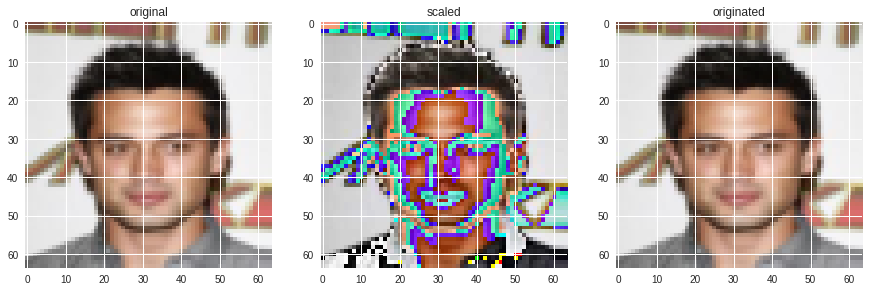

In [5]:
img = misc.imread(path + black_hair.iloc[0, 0])
img = misc.imresize(img, (64, 64))
scaled_image = scale(img)

fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('original')
plt.subplot(1, 3, 2)
plt.imshow(scaled_image)
plt.title('scaled')
plt.subplot(1, 3, 3)
plt.imshow(originate(scaled_image))
plt.title('originated')
plt.show()

In [6]:
def generate_sample(samples):
    idx = [i for i in xrange(16)]
    fig, axes = plt.subplots(4, 4, sharex = True, sharey = True, figsize = (5,5))

    for ii, ax in zip(idx, axes.flatten()):
        ax.imshow(originate(samples[ii,:,:,:]), aspect = 'equal')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()

In [7]:
def huber_loss(logits, labels, max_gradient = 1.0):
    err = tf.abs(labels - logits)
    mg = tf.constant(max_gradient)
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

def generator(z, name, reuse = False, alpha = 0.2, training = True):
    with tf.variable_scope(name, reuse = reuse):
        x1 = tf.layers.conv2d(z, 64, 4, strides = 2, padding = 'same')
        bn1 = tf.layers.batch_normalization(x1, training = training)
        relu1 = tf.maximum(alpha * bn1, bn1)
                
        x2 = tf.layers.conv2d(relu1, 128, 4, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = training)
        relu2 = tf.maximum(alpha * bn2, bn2)
                
        x3 = tf.layers.conv2d(relu2, 256, 4, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = training)
        relu3 = tf.maximum(alpha * bn3, bn3)
                
        x4 = tf.layers.conv2d(relu3, 512, 4, strides = 2, padding = 'same')
        bn4 = tf.layers.batch_normalization(x4, training = training)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        x5 = tf.layers.conv2d(relu4, 100, 4, strides = 2, padding = 'same')
        bn5 = tf.layers.batch_normalization(x5, training = training)
        relu5 = tf.maximum(alpha * bn5, bn5)
                
        x6 = tf.layers.conv2d_transpose(relu5, 512, 4, strides = 2, padding = 'same')
        bn6 = tf.layers.batch_normalization(x6, training = training)
        relu6 = tf.maximum(alpha * bn6, bn6)
        
        x7 = tf.layers.conv2d_transpose(relu6, 256, 4, strides = 2, padding = 'same')
        bn7 = tf.layers.batch_normalization(x7, training = training)
        relu7 = tf.maximum(alpha * bn7, bn7)
        
        x8 = tf.layers.conv2d_transpose(relu7, 128, 4, strides = 2, padding = 'same')
        bn8 = tf.layers.batch_normalization(x8, training = training)
        relu8 = tf.maximum(alpha * bn8, bn8)
                
        x9 = tf.layers.conv2d_transpose(relu8, 64, 4, strides = 2, padding = 'same')
        bn9 = tf.layers.batch_normalization(x9, training = training)
        relu9 = tf.maximum(alpha * bn9, bn9)    
        x10 = tf.layers.conv2d_transpose(relu9, 3, 5, strides = 2, padding = 'same')
                
        return tf.nn.tanh(x10)
                
def discriminator(z, name, reuse = False, alpha = 0.2):
    with tf.variable_scope(name, reuse = reuse):
        x1 = tf.layers.conv2d(z, 64, 4, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
                
        x2 = tf.layers.conv2d(relu1, 128, 4, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
                
        x3 = tf.layers.conv2d(relu2, 256, 4, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
                
        x4 = tf.layers.conv2d(relu3, 512, 4, strides = 2, padding = 'same')
        bn4 = tf.layers.batch_normalization(x4, training = True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        flat = tf.reshape(relu4, (-1, 4 * 4 * 512))
        logits = tf.layers.dense(flat, 1)
        
        return logits

In [8]:
class standardGAN:
    
    def __init__(self, learning_rate = 0.0002, alpha = 0.2):
        
        self.X = tf.placeholder(tf.float32, (None, 64, 64, 3))
        self.Y = tf.placeholder(tf.float32, (None, 64, 64, 3))
        
        g_model = generator(self.X, 'generator', alpha = alpha)
        self.g_out = generator(self.X, 'generator', reuse = True, training = False)
        d_logits_real = discriminator(self.Y, 'discriminator', alpha = alpha)
        d_logits_fake = discriminator(g_model, 'discriminator', reuse = True, alpha = alpha)
        
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_logits_real)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_logits_real)))
        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_logits_real)))
        
        self.d_loss = d_loss_real + d_loss_fake
        
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        self.d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = 0.5, beta2 = 0.999).minimize(self.d_loss, var_list = d_vars)
        self.g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = 0.5, beta2 = 0.999).minimize(self.g_loss, var_list = g_vars)
        
class GAN_with_huber:
    
    def __init__(self, learning_rate = 0.0002, alpha = 0.2):
        
        self.X = tf.placeholder(tf.float32, (None, 64, 64, 3))
        self.Y = tf.placeholder(tf.float32, (None, 64, 64, 3))
        g_model = generator(self.X, 'generator_AB', alpha = alpha)
        self.g_out = generator(self.X, 'generator_AB', reuse = True, training = False)
        g_huber = generator(g_model, 'generator_BA', alpha = alpha)
        
        l_const_a = tf.reduce_mean(huber_loss(g_huber, self.X))
        
        d_logits_real = discriminator(self.Y, 'discriminator', alpha = alpha)
        d_logits_fake = discriminator(g_model, 'discriminator', reuse = True, alpha = alpha)
        
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_logits_real)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_logits_real)))
        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_logits_real)))
        
        self.d_loss = d_loss_real + d_loss_fake
        self.g_loss += l_const_a
        
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars_AB = [var for var in t_vars if var.name.startswith('generator_AB')]
        g_vars_BA = [var for var in t_vars if var.name.startswith('generator_BA')]

        self.d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = 0.5, beta2 = 0.999).minimize(self.d_loss, var_list = d_vars)
        self.g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = 0.5, beta2 = 0.999).minimize(self.g_loss, var_list = g_vars_AB + g_vars_BA)
        
class DiscoGAN:
    
    def __init__(self, learning_rate = 0.0002, alpha = 0.2):
        
        self.X = tf.placeholder(tf.float32, (None, 64, 64, 3))
        self.Y = tf.placeholder(tf.float32, (None, 64, 64, 3))
        
        g_AB_model = generator(self.X, 'generator_AB', alpha = alpha)
        g_BA_model = generator(self.Y, 'generator_BA', alpha = alpha)
        
        self.g_out_AB = generator(self.X, 'generator_AB', reuse = True, training = False)
        self.g_out_BA = generator(self.Y, 'generator_BA', reuse = True, training = False)
        
        g_huber_A = generator_BA_reuse(g_AB_model, 'generator_BA', reuse = True, alpha = alpha)
        g_huber_B = generator_AB_reuse(g_BA_model, 'generator_AB', reuse = True, alpha = alpha)
        
        l_const_a = tf.reduce_mean(huber_loss(g_huber_A, self.X))
        l_const_b = tf.reduce_mean(huber_loss(g_huber_B, self.Y))
        
        d_logits_real_A = discriminator(self.Y, 'discriminator_A', alpha = alpha)
        d_logits_fake_A = discriminator(g_AB_model, 'discriminator_A', reuse = True, alpha = alpha)
        
        d_logits_real_B = discriminator(self.X, 'discriminator_B', alpha = alpha)
        d_logits_fake_B = discriminator(g_BA_model, 'discriminator_B', reuse = True, alpha = alpha)
        
        d_loss_real_A = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real_A, labels = tf.ones_like(d_logits_real_A)))
        d_loss_fake_A = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake_A, labels = tf.zeros_like(d_logits_fake_A)))
        self.g_loss_AB = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake_A, labels = tf.ones_like(d_logits_real_A)))
        
        d_loss_real_B = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real_B, labels = tf.ones_like(d_logits_real_B)))
        d_loss_fake_B = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake_B, labels = tf.zeros_like(d_logits_fake_B)))
        self.g_loss_BA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake_B, labels = tf.ones_like(d_logits_real_B)))
        
        self.d_loss = d_loss_real_A + d_loss_fake_A + d_loss_real_B + d_loss_fake_B
        self.g_loss = self.g_loss_AB + self.g_loss_BA + l_const_a + l_const_b
        
        t_vars = tf.trainable_variables()
        d_vars_A = [var for var in t_vars if var.name.startswith('discriminator_A')]
        d_vars_B = [var for var in t_vars if var.name.startswith('discriminator_B')]
        g_vars_AB = [var for var in t_vars if var.name.startswith('generator_AB')]
        g_vars_BA = [var for var in t_vars if var.name.startswith('generator_BA')]
        
        self.d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = 0.5, beta2 = 0.999).minimize(self.d_loss, var_list = d_vars_A + d_vars_B)
        self.g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = 0.5, beta2 = 0.999).minimize(self.g_loss, var_list = g_vars_AB + g_vars_BA)

Train Standard GAN

In [9]:
def train(model, X, Y, batch, epoch):
    LOSS_D, LOSS_G = [], []
    for i in xrange(epoch):
        g_loss, d_loss = 0, 0
        for k in xrange(0, (X.shape[0] // batch) * batch, batch):
            batch_x = np.zeros((batch, 64, 64, 3), dtype = np.float32)
            batch_y = np.zeros((batch, 64, 64, 3), dtype = np.float32)
            for n in xrange(batch):
                img_x = misc.imread(path + X.iloc[k + n, 0])
                img_x = misc.imresize(img_x, (64, 64))
                img_y = misc.imread(path + Y.iloc[k + n, 0])
                img_y = misc.imresize(img_y, (64, 64))
                batch_x[n, :, :, :] = scale(img_x)
                batch_y[n, :, :, :] = scale(img_y)
            _, lossd = sess.run([model.d_train_opt, model.d_loss], feed_dict = {model.X: batch_x, model.Y: batch_y})
            _, lossg = sess.run([model.g_train_opt, model.g_loss], feed_dict = {model.X: batch_x, model.Y: batch_y})
            g_loss += lossg; d_loss += lossd
        g_loss /= (X.shape[0] // batch); d_loss /= (X.shape[0] // batch)
        
        print("Epoch {}/{}".format(i + 1, EPOCH), "Discriminator Loss: {}".format(d_loss), "Generator Loss: {}".format(g_loss))
        LOSS_G.append(g_loss); LOSS_D.append(d_loss)
        
        batch_x = np.zeros((16, 64, 64, 3), dtype = np.float32)
        batch_y = np.zeros((16, 64, 64, 3), dtype = np.float32)
        
        for n in xrange(16):
            img_x = misc.imread(path + X.iloc[n, 0])
            img_x = misc.imresize(img_x, (64, 64))
            img_y = misc.imread(path + Y.iloc[n, 0])
            img_y = misc.imresize(img_y, (64, 64))
            batch_x[n, :, :, :] = scale(img_x)
            batch_y[n, :, :, :] = scale(img_y)
        
        # if the model is discoGAN
        try:
            outputs = sess.run(model.g_out_AB, feed_dict = {model.X: batch_x})
            print 'GENERATOR A'
            generate_sample(outputs)
            print 'GENERATOR B'
            outputs = sess.run(model.g_out_BA, feed_dict = {model.Y: batch_y})
            generate_sample(outputs)
        
        # if the model is not discoGAN
        except:
            outputs = sess.run(model.g_out, feed_dict = {model.X: batch_x})
            generate_sample(outputs)
    
    epoch = [i for i in xrange(len(LOSS_D))]
    plt.plot(epoch,LOSS_D, label = 'Discriminator', alpha = 0.5)
    plt.plot(epoch, LOSS_G, label = 'Generator', alpha = 0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [10]:
EPOCH = 5
BATCH_SIZE = 128

I will train for 5 epoch and 128 batch size only, to see, how much the networks learned in a short period

('Epoch 1/5...', 'Discriminator Loss: 1.63631684696', 'Generator Loss: 3.96951823968')


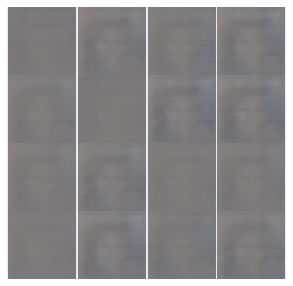

('Epoch 2/5...', 'Discriminator Loss: 1.2313120688', 'Generator Loss: 2.58018022585')


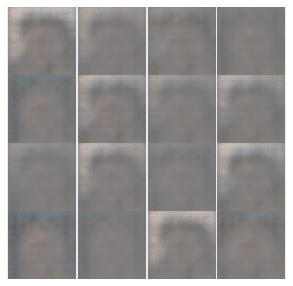

('Epoch 3/5...', 'Discriminator Loss: 1.20808830685', 'Generator Loss: 2.32643155104')


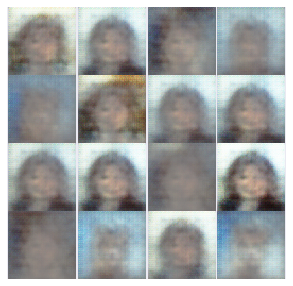

('Epoch 4/5...', 'Discriminator Loss: 1.07398742246', 'Generator Loss: 2.94111842032')


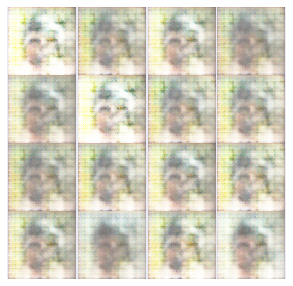

('Epoch 5/5...', 'Discriminator Loss: 1.04062212908', 'Generator Loss: 3.2834325727')


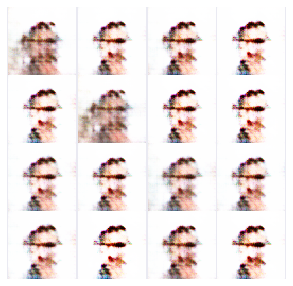

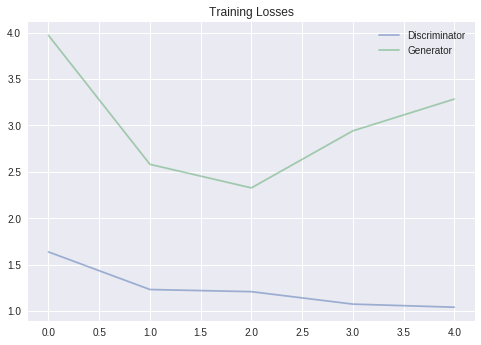

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = standardGAN()
sess.run(tf.global_variables_initializer())
train(model, black_hair, brown_hair, BATCH_SIZE, EPOCH)

In [12]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = GAN_with_huber()
sess.run(tf.global_variables_initializer())
train(model, black_hair, brown_hair, BATCH_SIZE, EPOCH)

ResourceExhaustedError: OOM when allocating tensor with shape[128,64,32,32]
	 [[Node: gradients_1/generator_BA/conv2d_transpose_5/conv2d_transpose_grad/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_1/generator_BA/conv2d_transpose_5/BiasAdd_grad/tuple/control_dependency, generator_BA/conv2d_transpose_4/kernel/read)]]

Caused by op u'gradients_1/generator_BA/conv2d_transpose_5/conv2d_transpose_grad/Conv2D', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-fdd68dc69ce9>", line 3, in <module>
    model = GAN_with_huber()
  File "<ipython-input-8-7a92cf6b4872>", line 54, in __init__
    self.g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = 0.5, beta2 = 0.999).minimize(self.g_loss, var_list = g_vars_AB + g_vars_BA)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/optimizer.py", line 315, in minimize
    grad_loss=grad_loss)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/optimizer.py", line 386, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py", line 540, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py", line 346, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py", line 540, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_grad.py", line 50, in _Conv2DBackpropInputGrad
    op.get_attr("data_format"))]
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 399, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

...which was originally created as op u'generator_BA/conv2d_transpose_5/conv2d_transpose', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
[elided 19 identical lines from previous traceback]
  File "<ipython-input-12-fdd68dc69ce9>", line 3, in <module>
    model = GAN_with_huber()
  File "<ipython-input-8-7a92cf6b4872>", line 34, in __init__
    g_huber = generator(g_model, 'generator_BA', alpha = alpha)
  File "<ipython-input-7-b2e3f9615593>", line 45, in generator
    x10 = tf.layers.conv2d_transpose(relu9, 3, 5, strides = 2, padding = 'same')
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/layers/convolutional.py", line 1282, in conv2d_transpose
    return layer.apply(inputs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/layers/base.py", line 492, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/layers/base.py", line 441, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/layers/convolutional.py", line 1162, in call
    data_format=utils.convert_data_format(self.data_format, ndim=4))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 1046, in conv2d_transpose
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 488, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,64,32,32]
	 [[Node: gradients_1/generator_BA/conv2d_transpose_5/conv2d_transpose_grad/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_1/generator_BA/conv2d_transpose_5/BiasAdd_grad/tuple/control_dependency, generator_BA/conv2d_transpose_4/kernel/read)]]


In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = DiscoGAN()
sess.run(tf.global_variables_initializer())
train(model, black_hair, brown_hair, BATCH_SIZE, EPOCH)